In [8]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import math
import random
import copy

In [73]:
base = "/Users/yashodeepmahapatra/Desktop/Text-Mining-1/bbc/"
os.chdir(base)
folders = os.listdir()
texts = []
for folder in folders:
    os.chdir(os.path.join(base, folder))
    files = os.listdir()
    for file in files:
        with open(file, 'rb') as curr_file:
            texts.append(str(curr_file.read()).lstrip("b\'").rstrip("b\'"))
# print(texts)
tfidf_vectorizer = TfidfVectorizer(texts, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(texts)
words = tfidf_vectorizer.get_feature_names()
vectors = tfidf.todense()
svd = TruncatedSVD(n_components = 3)
vectors_svd = svd.fit_transform(vectors)
vectors_svd = Normalizer().fit_transform(vectors_svd)
# print(vectors_svd.shape)
# fig=plt.figure()
# ax = Axes3D(fig)
# X = vectors_svd
# print(X)
# for j in range(len(X)):
#     ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
#     ax.view_init(330, 120)

/Users/yashodeepmahapatra/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [74]:
class PSO:
    def __init__(self, input_space, num_clusters = 5, n_components = 3, num_particles = 3, iterations = 100):
        assert(num_clusters>0)
        self.num_clusters = num_clusters
        self.n_components = n_components
        self.num_particles = num_particles
        self.input_space = input_space
        self.global_solution = np.zeros((num_clusters, n_components))
        self.local_solution = np.zeros((num_particles, num_clusters, n_components))
        self.global_best = -1 * math.inf
        self.local_best = np.full((num_particles), -1 * math.inf)
        self.iterations = iterations
        self.r1 = random.uniform(0, 1)
        self.r2 = random.uniform(0, 1)

    def distance(self, X1, X2, type = "euclidean"):
        assert(len(X1)==len(X2))
        X1 = np.array(X1)
        X2 = np.array(X2)
        if(type=="euclidean"):
            return np.sqrt(np.sum(np.square(X1-X2)))
        if type=="cosine":
            return np.sum(X1 * X2)/(np.sqrt(np.sum(np.square(X1))) * np.sqrt(np.sum(np.square(X2))))
    
    def fitness(self, X, particle):
        assert(len(X)==self.num_clusters)
        assert(len(X[0][0])==self.n_components)
        assert(len(particle)==self.num_clusters)
        assert(len(particle[0])==self.n_components)
        # X = np.array(X)
        # particle = np.array(particle)
        # Jc = 0
        # for i in range(self.num_clusters):
        #     Jc += np.sum(np.sqrt(np.sum(np.square(particle[i] - X[i]), axis = 1)))
        # return 1/(1+Jc)
        svd = TruncatedSVD(n_components = self.n_components - 1)
        U = []
        for i in range(self.num_clusters):
            U.append(svd.fit_transform(X[i]))
        Jc = 0
        for i in range(self.num_clusters):
            for j in range(i+1, self.num_clusters):
                if(len(U[i])>1 and len(U[j])>1):
                    for k in range(self.n_components - 1):
                        Jc += self.distance(U[i][k], U[j][k], type = "cosine")
        return Jc



    def pso_init(self):
        #velocity, position init
        Xs = []
        for i in range(self.num_particles):
            X = [[] for _ in range(self.num_clusters)]
            for j in range(len(self.input_space)):
                lottery = random.randint(0,self.num_clusters-1)
                X[lottery].append(self.input_space[j])
            for k in range(self.num_clusters):
                if len(X[k])==0:
                    for l in range(self.num_clusters):
                        if len(X[l])>1:
                            pos = np.argmax(np.sum(np.square(X[l] - new_position[l]),axis = 1))
                            X[k].append(X[l][pos])
                            del(X[l][pos])
                            break
            Xs.append(X)
        for i in range(self.num_particles):
            for j in range(self.num_clusters):
                self.local_solution[i][j] = np.average(Xs[i][j], axis=0)
            self.local_best[i] = self.fitness(Xs[i], self.local_solution[i])
        index = -1
        for i in range(self.num_particles):
            if self.local_best[i]>self.global_best:
                self.global_best = self.local_best[i]
                index = i
        if index != -1:
            self.global_solution = copy.deepcopy(self.local_solution[i])

        self.component_limit_min = np.min(self.input_space, axis = 0)
        self.component_limit_max = np.max(self.input_space, axis = 0)
        self.velocity_limit_max = 0.1 * (self.component_limit_max - self.component_limit_min)
        self.velocity_limit_min = -0.1 * (self.component_limit_max - self.component_limit_min)

        self.velocity = []
        for i in range(self.num_particles):
            velocity = [[] for _ in range(self.num_clusters)]
            for j in range(self.num_clusters):
                for k in range(self.n_components): 
                    velocity[j].append(random.uniform(self.velocity_limit_min[k], self.velocity_limit_max[k]))
            self.velocity.append(velocity)
        self.velocity = np.array(self.velocity)
    
    def converge(self, w1 = 0.9, w2 = 0.4, c1 = 1, c2 = 3):
        self.w1 = w1
        self.w2 = w2
        self.c1 = c1
        self.c2 = c2
        self.pso_init()
        curr_position = copy.deepcopy(self.local_solution)
        curr_velocity = copy.deepcopy(self.velocity)
        for i in range(self.iterations):
            print("Iteration #"+str(i)+"....")
            w = (w1 - w2)*(self.iterations - i)/(self.iterations) + w2
            for j in range(self.num_particles):
                new_position = curr_position[j] + curr_velocity[j]
                new_velocity = w*curr_velocity[j] + self.c1*self.r1*(self.local_solution[j] - curr_position[j]) + self.c2*self.r2*(self.global_solution - curr_position[j])
                for k in range(self.num_clusters):
                    for l in range(self.n_components):
                        if(new_position[k][l]>self.component_limit_max[l]):
                            new_position[k][l] = self.component_limit_max[l]
                        elif(new_position[k][l]<self.component_limit_min[l]):
                            new_position[k][l] = self.component_limit_min[l]
                        if(new_velocity[k][l]>self.velocity_limit_max[l]):
                            new_velocity[k][l] = self.velocity_limit_max[l]
                        elif(new_velocity[k][l]<self.velocity_limit_min[l]):
                            new_velocity[k][l] = self.velocity_limit_min[l]
                X = [[] for _ in range(self.num_clusters)]
                for k in range(len(self.input_space)):
                    distances = np.divide(np.sum((new_position * self.input_space[k]), axis = 1), np.dot(np.sqrt(np.sum(np.square(new_position), axis = 1)), np.sqrt(np.sum(np.square(self.input_space[k])))))
                    # distances = np.sum(np.square(new_position - self.input_space[k]),axis = 1)
                    X[np.argmax(distances)].append(self.input_space[k])
                for k in range(self.num_clusters):
                    if len(X[k])==0:
                        for l in range(self.num_clusters):
                            if len(X[l])>1:
                                pos = np.argmax(np.sum(np.square(X[l] - new_position[l]),axis = 1))
                                X[k].append(X[l][pos])
                                del(X[l][pos])
                                break
                for k in range(self.num_clusters):
                    curr_position[j][k] = np.average(X[k], axis = 0)
                curr_velocity[j] = new_velocity
                new_fitness = self.fitness(X, curr_position[j])
                # if j==0:
                #     print()
                if new_fitness > self.local_best[j]:
                    print("Updated particle best...")
                    # self.local_solution[j] = copy.deepcopy(new_position)
                    self.local_solution[j] = copy.deepcopy(curr_position[j])
                    self.local_best[j] = new_fitness
            for j in range(self.num_particles):
                index = -1
                if self.local_best[j] > self.global_best:
                    self.global_best = self.local_best[j]
                    index = j
                if index != -1:
                    print("Global value updated")
                    self.global_solution = copy.deepcopy(self.local_solution[index])
        
    def plot(self):
        X = [[] for _ in range(self.num_clusters)]
        for k in range(len(self.input_space)):
            distances = np.divide(np.sum((self.global_solution * self.input_space[k]), axis = 1), np.dot(np.sqrt(np.sum(np.square(self.global_solution), axis = 1)), np.sqrt(np.sum(np.square(self.input_space[k])))))
            # distances = np.sum(np.square(self.global_solution - self.input_space[k]),axis = 1)
            X[np.argmax(distances)].append(self.input_space[k])
        fig=plt.figure()
        ax = Axes3D(fig)
        colors=['r','m','y','k','c','b','g']
        for i in range(self.num_clusters):
            for j in range(len(X[i])):
                ax.scatter(X[i][j][0], X[i][j][1], X[i][j][2], color = colors[i], marker = 'o')
        for i in range(self.num_clusters):
            ax.scatter(self.global_solution[i][0],self.global_solution[i][1],self.global_solution[i][2],c='b',marker='X')


In [75]:
p1 = PSO(vectors_svd, num_clusters = 7, num_particles = 30, iterations = 100)

In [76]:
p1.converge(w1 = 0.9, w2 = 0.4, c1 = 2.5, c2 = 0.5)

Iteration #0....
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Global value updated
Global value updated
Iteration #1....
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...
Updated particle best...

In [77]:
X = [[] for _ in range(p1.num_clusters)]
for k in range(len(p1.input_space)):
        distances = np.divide(np.sum((p1.global_solution * p1.input_space[k]), axis = 1), np.dot(np.sqrt(np.sum(np.square(p1.global_solution), axis = 1)), np.sqrt(np.sum(np.square(p1.input_space[k])))))
            # distances = np.sum(np.square(self.global_solution - self.input_space[k]),axis = 1)
        X[np.argmax(distances)].append(p1.input_space[k])

In [78]:
X = [[] for _ in range(p1.num_clusters)]
for k in range(len(p1.input_space)):
    distances = np.divide(np.sum((p1.global_solution * p1.input_space[k]), axis = 1), np.dot(np.sqrt(np.sum(np.square(p1.global_solution), axis = 1)), np.sqrt(np.sum(np.square(p1.input_space[k])))))
            # distances = np.sum(np.square(self.global_solution - self.input_space[k]),axis = 1)
    X[np.argmax(distances)].append(p1.input_space[k])
print(len(X[0]))
print(len(X[1]))
print(len(X[2]))
print(len(X[3]))
print(len(X[4]))
print(len(X[5]))
print(len(X[6]))

226
272
401
122
654
305
245


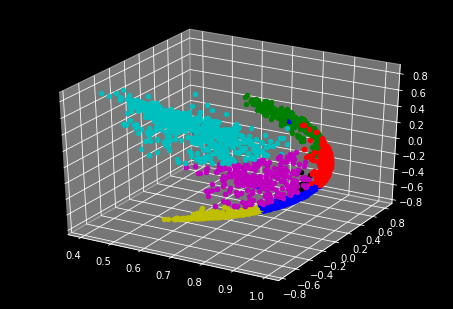

In [81]:
def plot():
        fig=plt.figure()
        ax = Axes3D(fig)
        # ax.view_init(330, 0)
        colors=['r','m','y','k','c','b','g']
        for i in range(p1.num_clusters):
            for j in range(len(X[i])):
                ax.scatter(X[i][j][0], X[i][j][1], X[i][j][2], color = colors[i], marker = 'o')
        for i in range(p1.num_clusters):
            ax.scatter(p1.global_solution[i][0],p1.global_solution[i][1],p1.global_solution[i][2],c='b',marker='X')
plot()